# Import
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [170]:
import os
import sys
import glob
import gc

import pandas as pd
import numpy as np
import pyarrow.parquet as pq

import sqlalchemy
from sqlalchemy import create_engine
import psycopg2 as pg

from dotenv import load_dotenv

import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [11]:
raw_path = 'D:/Users/User/Desktop/Julia/DE/data/raw/' 
processed_path = 'D:/Users/User/Desktop/Julia/DE/data/processed/' 

file_list = glob.glob(os.path.join(raw_path, 'green_tripdata_2025-*.parquet'))

df_list = []

for file in file_list:
    df = pd.read_parquet(file)
    df_list.append(df)

green_taxi = pd.concat(df_list, ignore_index=True)

output_file = os.path.join(processed_path, 'green_tripdata_2025.parquet')
green_taxi.to_parquet(output_file, engine='pyarrow')

In [12]:
green_taxi = pd.read_parquet('D:/Users/User/Desktop/Julia/NYC_Taxi/data/processed/green_tripdata_2025.parquet')
green_taxi

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.5,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.00
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.5,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.00
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.00
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,0.5,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.00
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,0.5,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303402,2,2025-06-30 20:35:00,2025-06-30 20:43:00,None,NaN,152,42,NaN,1.26,13.58,...,0.5,3.02,0.00,NaN,1.0,18.10,NaN,NaN,NaN,0.00
303403,2,2025-06-30 21:35:00,2025-06-30 21:46:00,None,NaN,66,87,NaN,2.20,12.88,...,0.5,3.58,0.00,NaN,1.0,21.46,NaN,NaN,NaN,0.75
303404,2,2025-06-30 22:51:00,2025-06-30 23:14:00,None,NaN,33,164,NaN,6.60,29.51,...,0.5,6.90,0.00,NaN,1.0,41.41,NaN,NaN,NaN,0.75
303405,2,2025-06-30 22:13:00,2025-06-30 22:25:00,None,NaN,42,236,NaN,2.52,18.23,...,0.5,4.50,0.00,NaN,1.0,26.98,NaN,NaN,NaN,0.00


In [13]:
print(green_taxi.dtypes)

VendorID                          int32
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int32
DOLocationID                      int32
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
cbd_congestion_fee              float64
dtype: object


In [177]:
def train_tip_prediction_model(df: pd.DataFrame, training_months: list, testing_months: list):
    if df.empty:
        print("Empty Data")
        return

    TARGET = 'tip_amount'

    Features = [
        "passenger_count",
        "trip_distance",
        "RatecodeID",
        "extra",
        "mta_tax",
        "tolls_amount",
        "improvement_surcharge",
        "congestion_surcharge",
        "trip_type",
        "cbd_congestion_fee",
        "pickup_hour", 
        "trip_duration_minutes",
    ]

    df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
    df['trip_duration_minutes'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60
    df['pickup_month_str'] = df['lpep_pickup_datetime'].dt.strftime('%m')

    train_df = df[df['pickup_month_str'].isin(training_months)].copy()
    test_df = df[df['pickup_month_str'].isin(testing_months)].copy()

    train_df = train_df[[*Features, TARGET]].dropna()
    test_df = test_df[[*Features, TARGET]].dropna()

    X_train = train_df[Features]
    y_train = train_df[TARGET]
    X_test = test_df[Features]
    y_test = test_df[TARGET]

    categorical_features = ['RatecodeID', 'pickup_hour', 'trip_type']
    numerical_features = [col for col in train_df.columns if col not in categorical_features and col not in TARGET]

    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    model_pipeline.fit(X_train, y_train)
    print("Train Finished.")

    y_pred = model_pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    
    # model_output_path = 'model/green_taxi_tip_prediction_model.joblib'
    # joblib.dump(model_pipeline, model_output_path)
    # print(f"\n Save Model: {model_output_path}")

In [178]:
TRAINING_MONTHS = ['01', '02', '03', '04'] 
TESTING_MONTHS = ['05', '06'] 

train_tip_prediction_model(green_taxi, TRAINING_MONTHS, TESTING_MONTHS)

Train Finished.
Mean Squared Error (MSE): 11.71
Root Mean Squared Error (RMSE): 3.42
R-squared (R2): 0.14


# SQL

In [ ]:
def import_monthly_data_to_db(data_path: str, target_months: list, data_name: str):
    db_user = 'postgres'
    db_password = '100888'
    db_host = 'localhost'
    db_port = '5432'
    db_name = 'NYC_Taxi'
    table_name = 'green_tripdata'

    db_connection_str = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
    engine = create_engine(db_connection_str)

    try:
        file_pattern = os.path.join(data_path, data_name)
        all_parquet_files = glob.glob(file_pattern)

        
        files_to_import = []
        for file_path in all_parquet_files:
            filename = os.path.basename(file_path)
            try:
                month_str = filename.split('-')[1].split('.')[0]
                if month_str in target_months:
                    files_to_import.append(file_path)
            except IndexError:
                print(f"Warning: '{filename}' Skip month.")

        files_to_import.sort()

        all_dfs = []    

        for file_path in files_to_import:
            filename = os.path.basename(file_path)
            df = pd.read_parquet(file_path)
            all_dfs.append(df)
            print(f"'{filename}' Finish.")
            del df
            gc.collect()

        combined_df = pd.concat(all_dfs, ignore_index=True)
        print(f"All Columns: {len(combined_df.columns)}")

        del all_dfs
        gc.collect()

        combined_df.to_sql(table_name, engine, if_exists='append', index=False)
        print(f"{target_months} data imported to PostgreSQL.")

    except Exception as e:
        print(f"Error occurred: {e}")

    finally:
        if 'engine' in locals() and engine:
            engine.dispose()
        print("\n End of Process.")

In [ ]:
if __name__ == '__main__':
    RAW_DATA_PATH = 'D:/Users/User/Desktop/Julia/NYC_Taxi/data/raw/' 
    target_months = ['01', '02', '03', '04', '05', '06']
    data_name = 'green_tripdata_2025-*.parquet'
    import_monthly_data_to_db(RAW_DATA_PATH, target_months, data_name)

In [ ]:
db_user = 'postgres'
db_password = '100888'
db_host = 'localhost'
db_port = '5432'
db_name = 'NYC_Taxi'
table_name = 'green_tripdata'

db_connection_str = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(db_connection_str)

query = """
SELECT
    "VendorID",
    "lpep_pickup_datetime",
    "lpep_dropoff_datetime",
    "passenger_count",
    "trip_distance",
    "RatecodeID",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "ehail_fee",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "cbd_congestion_fee"
FROM green_tripdata
WHERE "payment_type" = 1
  AND "fare_amount" > 0
  AND "tip_amount" >= 0
  AND "trip_distance" > 0
  AND "total_amount" > 0;
"""
parquet_path = 'D:/Users/User/Desktop/Julia/NYC_Taxi/data/processed/green_tripdata_filtered.parquet'

df = pd.read_sql(query, engine)

df.to_parquet(parquet_path, index=False)

print(df.head())

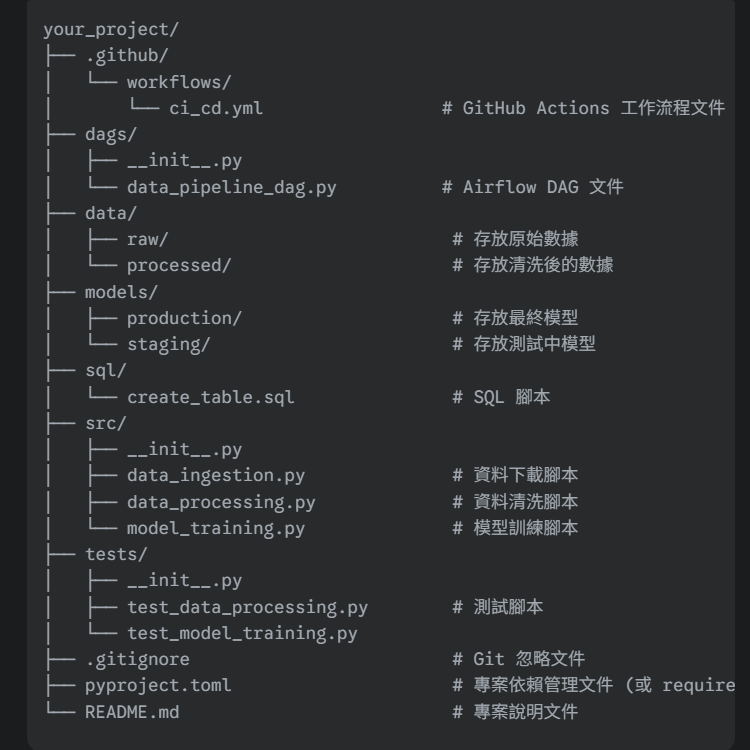